In [74]:
# Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report

import shap

# Load merged features
df = pd.read_csv("features_filt.csv")
print(df.shape)
df.head()


(3000, 1544)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,...,icd_chapter_M,icd_chapter_N,icd_chapter_Q,icd_chapter_R,icd_chapter_S,icd_chapter_T,icd_chapter_V,icd_chapter_W,icd_chapter_Y,icd_chapter_Z
0,15726459,22744101,30000831,Coronary Care Unit (CCU),Coronary Care Unit (CCU),4/17/2140 21:26,4/20/2140 14:21,2.705139,4/17/2140 21:25,5/18/2140 21:00,...,0,1,0,1,0,0,0,0,0,1
1,18172623,24751715,30005160,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),8/31/2130 23:08,9/3/2130 10:33,2.476157,8/31/2130 20:39,10/8/2130 17:00,...,1,1,0,1,0,1,0,0,1,1
2,19448158,28451027,30008046,Neuro Intermediate,Neuro Intermediate,1/26/2154 17:39,1/30/2154 21:17,4.151273,1/26/2154 16:20,1/30/2154 20:45,...,1,1,0,1,0,0,0,0,0,1
3,12407894,20375008,30014984,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),7/1/2127 7:20,7/3/2127 16:15,2.371771,7/1/2127 2:04,7/14/2127 11:23,...,0,1,0,1,0,0,0,0,0,1
4,11348907,24524153,30016014,Coronary Care Unit (CCU),Coronary Care Unit (CCU),10/6/2110 18:18,10/8/2110 2:00,1.320567,10/6/2110 10:23,10/16/2110 13:00,...,0,0,0,0,0,0,1,0,0,0


In [75]:
# Convert True/False to 1/0
df['early_readmit'] = df['early_readmit'].astype(int)

# Check the conversion
print(df['early_readmit'].value_counts())



early_readmit
0    2000
1    1000
Name: count, dtype: int64


In [76]:
#print(df.columns.tolist())


In [77]:
# Move target column to the end
target = 'early_readmit'
cols = [c for c in df.columns if c != target] + [target]
df = df[cols]

# Check the new column order
print(df.head())


   subject_id   hadm_id   stay_id  \
0    15726459  22744101  30000831   
1    18172623  24751715  30005160   
2    19448158  28451027  30008046   
3    12407894  20375008  30014984   
4    11348907  24524153  30016014   

                                     first_careunit  \
0                          Coronary Care Unit (CCU)   
1  Medical/Surgical Intensive Care Unit (MICU/SICU)   
2                                Neuro Intermediate   
3               Surgical Intensive Care Unit (SICU)   
4                          Coronary Care Unit (CCU)   

                                      last_careunit           intime  \
0                          Coronary Care Unit (CCU)  4/17/2140 21:26   
1  Medical/Surgical Intensive Care Unit (MICU/SICU)  8/31/2130 23:08   
2                                Neuro Intermediate  1/26/2154 17:39   
3               Surgical Intensive Care Unit (SICU)    7/1/2127 7:20   
4                          Coronary Care Unit (CCU)  10/6/2110 18:18   

           ou

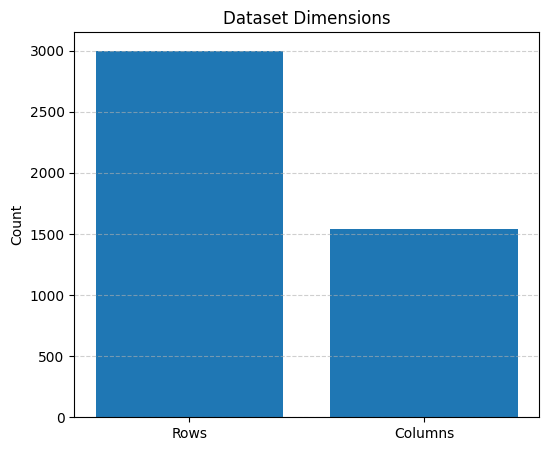

In [78]:
import matplotlib.pyplot as plt

# Dataset shape
rows = 3000
cols = 1544

plt.figure(figsize=(6,5))
plt.bar(['Rows', 'Columns'], [rows, cols])
plt.title('Dataset Dimensions')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [79]:
df = df.drop(['subject_id', 'hadm_id', 'stay_id'], axis=1)
df.head()


,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,hospital_expire_flag,gender,anchor_age,...,icd_chapter_N,icd_chapter_Q,icd_chapter_R,icd_chapter_S,icd_chapter_T,icd_chapter_V,icd_chapter_W,icd_chapter_Y,icd_chapter_Z,early_readmit
0,Coronary Care Unit (CCU),Coronary Care Unit (CCU),4/17/2140 21:26,4/20/2140 14:21,2.705139,4/17/2140 21:25,5/18/2140 21:00,0,M,78,...,1,0,1,0,0,0,0,0,1,1
1,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),8/31/2130 23:08,9/3/2130 10:33,2.476157,8/31/2130 20:39,10/8/2130 17:00,0,M,57,...,1,0,1,0,1,0,0,1,1,0
2,Neuro Intermediate,Neuro Intermediate,1/26/2154 17:39,1/30/2154 21:17,4.151273,1/26/2154 16:20,1/30/2154 20:45,0,M,75,...,1,0,1,0,0,0,0,0,1,0
3,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),7/1/2127 7:20,7/3/2127 16:15,2.371771,7/1/2127 2:04,7/14/2127 11:23,0,M,44,...,1,0,1,0,0,0,0,0,1,1
4,Coronary Care Unit (CCU),Coronary Care Unit (CCU),10/6/2110 18:18,10/8/2110 2:00,1.320567,10/6/2110 10:23,10/16/2110 13:00,0,M,76,...,0,0,0,0,0,1,0,0,0,1


In [80]:
# Convert datetime columns to pandas datetime
datetime_cols = ['admittime', 'dischtime', 'intime', 'outtime']
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col])

# Create useful numeric features
df['icu_los_hours'] = (df['outtime'] - df['intime']).dt.total_seconds() / 3600
df['hospital_los_hours'] = (df['dischtime'] - df['admittime']).dt.total_seconds() / 3600
df['admit_hour'] = df['admittime'].dt.hour
df['admit_dayofweek'] = df['admittime'].dt.dayofweek
df['icu_admit_hour'] = df['intime'].dt.hour
df['icu_admit_dayofweek'] = df['intime'].dt.dayofweek

# Drop the raw datetime columns
df = df.drop(columns=datetime_cols)

# Print the new columns and first few rows
print(df[['icu_los_hours', 'hospital_los_hours', 'admit_hour', 'admit_dayofweek', 'icu_admit_hour', 'icu_admit_dayofweek']].head())


   icu_los_hours  hospital_los_hours  admit_hour  admit_dayofweek  \
0      64.916667          743.583333          21                6   
1      59.416667          908.350000          20                3   
2      99.633333          100.416667          16                5   
3      56.916667          321.316667           2                1   
4      31.700000          242.616667          10                0   

   icu_admit_hour  icu_admit_dayofweek  
0              21                    6  
1              23                    3  
2              17                    5  
3               7                    1  
4              18                    0  


In [81]:
# Check the DataFrame after creating new numeric features
print(df.head())

# Check all columns
print(df.columns)


                                     first_careunit  \
0                          Coronary Care Unit (CCU)   
1  Medical/Surgical Intensive Care Unit (MICU/SICU)   
2                                Neuro Intermediate   
3               Surgical Intensive Care Unit (SICU)   
4                          Coronary Care Unit (CCU)   

                                      last_careunit       los  \
0                          Coronary Care Unit (CCU)  2.705139   
1  Medical/Surgical Intensive Care Unit (MICU/SICU)  2.476157   
2                                Neuro Intermediate  4.151273   
3               Surgical Intensive Care Unit (SICU)  2.371771   
4                          Coronary Care Unit (CCU)  1.320567   

   hospital_expire_flag gender  anchor_age       next_intime  next_stay_id  \
0                     0      M          78   4/20/2140 22:06    36689689.0   
1                     0      M          57  10/26/2130 15:36    38598068.0   
2                     0      M          75  

In [82]:
# Gender: map 'M'->1, 'F'->0
df['gender'] = df['gender'].map({'M':1, 'F':0})
df


,first_careunit,last_careunit,los,hospital_expire_flag,gender,anchor_age,next_intime,next_stay_id,gap_hours,window_end,...,icd_chapter_W,icd_chapter_Y,icd_chapter_Z,early_readmit,icu_los_hours,hospital_los_hours,admit_hour,admit_dayofweek,icu_admit_hour,icu_admit_dayofweek
0,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2.705139,0,1,78,4/20/2140 22:06,36689689.0,7.738611,4/20/2140 14:21,...,0,0,1,1,64.916667,743.583333,21,6,21,6
1,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2.476157,0,1,57,10/26/2130 15:36,38598068.0,1277.038889,9/3/2130 10:33,...,0,1,1,0,59.416667,908.350000,20,3,23,3
2,Neuro Intermediate,Neuro Intermediate,4.151273,0,1,75,NaN,NaN,NaN,1/30/2154 21:17,...,0,0,1,0,99.633333,100.416667,16,5,17,5
3,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2.371771,0,1,44,7/5/2127 18:00,32711047.0,49.742500,7/3/2127 16:15,...,0,0,1,1,56.916667,321.316667,2,1,7,1
4,Coronary Care Unit (CCU),Coronary Care Unit (CCU),1.320567,0,1,76,10/8/2110 2:16,34159119.0,0.273333,10/8/2110 2:00,...,0,0,0,1,31.700000,242.616667,10,0,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),1.500046,0,1,87,7/4/2123 10:56,36389310.0,67.517222,7/1/2123 15:25,...,1,1,1,1,36.000000,570.316667,22,4,3,2
2996,Coronary Care Unit (CCU),Coronary Care Unit (CCU),0.373310,0,0,46,2/23/2169 22:38,33738626.0,0.008333,2/23/2169 22:38,...,0,0,0,1,8.966667,484.666667,13,3,13,3
2997,Neuro Intermediate,Neuro Intermediate,5.088356,0,1,48,NaN,NaN,NaN,3/18/2148 1:56,...,0,0,1,0,122.116667,835.233333,22,1,23,1
2998,Neuro Intermediate,Neuro Intermediate,4.191412,0,0,52,NaN,NaN,NaN,12/7/2155 21:40,...,0,0,0,0,100.583333,173.816667,16,2,17,2


In [83]:
# One-hot encode first_careunit and last_careunit
df = pd.get_dummies(df, columns=['first_careunit', 'last_careunit'], drop_first=True)
df


,los,hospital_expire_flag,gender,anchor_age,next_intime,next_stay_id,gap_hours,window_end,window_start,discharge_year,...,last_careunit_Medical Intensive Care Unit (MICU),last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),last_careunit_Medicine/Cardiology Intermediate,last_careunit_Neuro Intermediate,last_careunit_Neuro Stepdown,last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),last_careunit_PACU,last_careunit_Surgery/Vascular/Intermediate,last_careunit_Surgical Intensive Care Unit (SICU),last_careunit_Trauma SICU (TSICU)
0,2.705139,0,1,78,4/20/2140 22:06,36689689.0,7.738611,4/20/2140 14:21,4/19/2140 14:21,2140,...,False,False,False,False,False,False,False,False,False,False
1,2.476157,0,1,57,10/26/2130 15:36,38598068.0,1277.038889,9/3/2130 10:33,9/2/2130 10:33,2130,...,False,True,False,False,False,False,False,False,False,False
2,4.151273,0,1,75,NaN,NaN,NaN,1/30/2154 21:17,1/29/2154 21:17,2154,...,False,False,False,True,False,False,False,False,False,False
3,2.371771,0,1,44,7/5/2127 18:00,32711047.0,49.742500,7/3/2127 16:15,7/2/2127 16:15,2127,...,False,False,False,False,False,False,False,False,True,False
4,1.320567,0,1,76,10/8/2110 2:16,34159119.0,0.273333,10/8/2110 2:00,10/7/2110 2:00,2110,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1.500046,0,1,87,7/4/2123 10:56,36389310.0,67.517222,7/1/2123 15:25,6/30/2123 15:25,2123,...,False,False,False,False,False,False,False,False,False,False
2996,0.373310,0,0,46,2/23/2169 22:38,33738626.0,0.008333,2/23/2169 22:38,2/22/2169 22:38,2169,...,False,False,False,False,False,False,False,False,False,False
2997,5.088356,0,1,48,NaN,NaN,NaN,3/18/2148 1:56,3/17/2148 1:56,2148,...,False,False,False,True,False,False,False,False,False,False
2998,4.191412,0,0,52,NaN,NaN,NaN,12/7/2155 21:40,12/6/2155 21:40,2155,...,False,False,False,True,False,False,False,False,False,False


In [84]:
# Convert all boolean columns to 0/1
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Check first few rows
print(df.head())


        los  hospital_expire_flag  gender  anchor_age       next_intime  \
0  2.705139                     0       1          78   4/20/2140 22:06   
1  2.476157                     0       1          57  10/26/2130 15:36   
2  4.151273                     0       1          75               NaN   
3  2.371771                     0       1          44    7/5/2127 18:00   
4  1.320567                     0       1          76    10/8/2110 2:16   

   next_stay_id    gap_hours       window_end     window_start  \
0    36689689.0     7.738611  4/20/2140 14:21  4/19/2140 14:21   
1    38598068.0  1277.038889   9/3/2130 10:33   9/2/2130 10:33   
2           NaN          NaN  1/30/2154 21:17  1/29/2154 21:17   
3    32711047.0    49.742500   7/3/2127 16:15   7/2/2127 16:15   
4    34159119.0     0.273333   10/8/2110 2:00   10/7/2110 2:00   

   discharge_year  ...  last_careunit_Medical Intensive Care Unit (MICU)  \
0            2140  ...                                                 0   


In [85]:
# Drop columns that contain future information
df = df.drop(columns=['next_intime', 'next_stay_id'])

# Check the remaining columns
print(df.columns)


Index(['los', 'hospital_expire_flag', 'gender', 'anchor_age', 'gap_hours',
       'window_end', 'window_start', 'discharge_year', 'label',
       'chart__last__18_gauge_dressing_occlusive_227367',
       ...
       'last_careunit_Medical Intensive Care Unit (MICU)',
       'last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'last_careunit_Medicine/Cardiology Intermediate',
       'last_careunit_Neuro Intermediate', 'last_careunit_Neuro Stepdown',
       'last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'last_careunit_PACU', 'last_careunit_Surgery/Vascular/Intermediate',
       'last_careunit_Surgical Intensive Care Unit (SICU)',
       'last_careunit_Trauma SICU (TSICU)'],
      dtype='object', length=1563)


In [86]:
# Drop columns that contain future information
df = df.drop(columns=['window_start', 'window_end'])

# Check remaining columns
print(df.columns)


Index(['los', 'hospital_expire_flag', 'gender', 'anchor_age', 'gap_hours',
       'discharge_year', 'label',
       'chart__last__18_gauge_dressing_occlusive_227367',
       'chart__last__18_gauge_placed_in_outside_facility_226137',
       'chart__last__18_gauge_placed_in_the_field_228099',
       ...
       'last_careunit_Medical Intensive Care Unit (MICU)',
       'last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'last_careunit_Medicine/Cardiology Intermediate',
       'last_careunit_Neuro Intermediate', 'last_careunit_Neuro Stepdown',
       'last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'last_careunit_PACU', 'last_careunit_Surgery/Vascular/Intermediate',
       'last_careunit_Surgical Intensive Care Unit (SICU)',
       'last_careunit_Trauma SICU (TSICU)'],
      dtype='object', length=1561)


In [87]:
# Move target column to the end
target = 'early_readmit'
cols = [c for c in df.columns if c != target] + [target]
df = df[cols]


In [88]:
# Check first few rows
print(df.head())

        los  hospital_expire_flag  gender  anchor_age    gap_hours  \
0  2.705139                     0       1          78     7.738611   
1  2.476157                     0       1          57  1277.038889   
2  4.151273                     0       1          75          NaN   
3  2.371771                     0       1          44    49.742500   
4  1.320567                     0       1          76     0.273333   

   discharge_year  label  chart__last__18_gauge_dressing_occlusive_227367  \
0            2140      1                                              1.0   
1            2130      0                                              NaN   
2            2154      0                                              NaN   
3            2127      1                                              NaN   
4            2110      1                                              1.0   

   chart__last__18_gauge_placed_in_outside_facility_226137  \
0                                                0.0  

In [89]:
[col for col in df.columns if col.startswith("icd")]
icd_chapter_cols = [col for col in df.columns if "chapter" in col.lower()]
print(icd_chapter_cols)


['icd_chapter_0', 'icd_chapter_1', 'icd_chapter_2', 'icd_chapter_3', 'icd_chapter_4', 'icd_chapter_5', 'icd_chapter_6', 'icd_chapter_7', 'icd_chapter_8', 'icd_chapter_9', 'icd_chapter_A', 'icd_chapter_B', 'icd_chapter_C', 'icd_chapter_D', 'icd_chapter_E', 'icd_chapter_F', 'icd_chapter_G', 'icd_chapter_H', 'icd_chapter_I', 'icd_chapter_J', 'icd_chapter_K', 'icd_chapter_L', 'icd_chapter_M', 'icd_chapter_N', 'icd_chapter_Q', 'icd_chapter_R', 'icd_chapter_S', 'icd_chapter_T', 'icd_chapter_V', 'icd_chapter_W', 'icd_chapter_Y', 'icd_chapter_Z']


In [90]:
icd_individual_cols = [
    col for col in df.columns 
    if col.startswith("icd_") and "chapter" not in col.lower()
]

print(len(icd_individual_cols))
print(icd_individual_cols[:20])


130
['icd_root_041', 'icd_root_070', 'icd_root_244', 'icd_root_250', 'icd_root_272', 'icd_root_274', 'icd_root_276', 'icd_root_278', 'icd_root_280', 'icd_root_285', 'icd_root_287', 'icd_root_288', 'icd_root_296', 'icd_root_300', 'icd_root_303', 'icd_root_305', 'icd_root_311', 'icd_root_327', 'icd_root_338', 'icd_root_345']


In [91]:
icd_chapter_cols = [col for col in df.columns if col.startswith("icd_chapter_")]
print("Number of ICD chapter columns:", len(icd_chapter_cols))


Number of ICD chapter columns: 32


In [92]:
icd_root_cols = [col for col in df.columns if col.startswith("icd_root_")]
print("Number of ICD root columns:", len(icd_root_cols))


Number of ICD root columns: 130


In [93]:
print(icd_chapter_cols)
print(icd_root_cols)


['icd_chapter_0', 'icd_chapter_1', 'icd_chapter_2', 'icd_chapter_3', 'icd_chapter_4', 'icd_chapter_5', 'icd_chapter_6', 'icd_chapter_7', 'icd_chapter_8', 'icd_chapter_9', 'icd_chapter_A', 'icd_chapter_B', 'icd_chapter_C', 'icd_chapter_D', 'icd_chapter_E', 'icd_chapter_F', 'icd_chapter_G', 'icd_chapter_H', 'icd_chapter_I', 'icd_chapter_J', 'icd_chapter_K', 'icd_chapter_L', 'icd_chapter_M', 'icd_chapter_N', 'icd_chapter_Q', 'icd_chapter_R', 'icd_chapter_S', 'icd_chapter_T', 'icd_chapter_V', 'icd_chapter_W', 'icd_chapter_Y', 'icd_chapter_Z']
['icd_root_041', 'icd_root_070', 'icd_root_244', 'icd_root_250', 'icd_root_272', 'icd_root_274', 'icd_root_276', 'icd_root_278', 'icd_root_280', 'icd_root_285', 'icd_root_287', 'icd_root_288', 'icd_root_296', 'icd_root_300', 'icd_root_303', 'icd_root_305', 'icd_root_311', 'icd_root_327', 'icd_root_338', 'icd_root_345', 'icd_root_348', 'icd_root_357', 'icd_root_401', 'icd_root_403', 'icd_root_412', 'icd_root_414', 'icd_root_424', 'icd_root_427', 'icd_r

In [94]:
icd_root_cols = [col for col in df.columns if col.startswith("icd_root_")]
df = df.drop(columns=icd_root_cols)


In [95]:
# After dropping columns

# Remaining ICD chapter columns
icd_chapter_cols_after = [c for c in df.columns if c.startswith("icd_chapter_")]
print("Remaining ICD chapter columns:", len(icd_chapter_cols_after))
print(icd_chapter_cols_after)

# Remaining ICD root columns
icd_root_cols_after = [c for c in df.columns if c.startswith("icd_root_")]
print("Remaining ICD root columns:", len(icd_root_cols_after))
print(icd_root_cols_after)


Remaining ICD chapter columns: 32
['icd_chapter_0', 'icd_chapter_1', 'icd_chapter_2', 'icd_chapter_3', 'icd_chapter_4', 'icd_chapter_5', 'icd_chapter_6', 'icd_chapter_7', 'icd_chapter_8', 'icd_chapter_9', 'icd_chapter_A', 'icd_chapter_B', 'icd_chapter_C', 'icd_chapter_D', 'icd_chapter_E', 'icd_chapter_F', 'icd_chapter_G', 'icd_chapter_H', 'icd_chapter_I', 'icd_chapter_J', 'icd_chapter_K', 'icd_chapter_L', 'icd_chapter_M', 'icd_chapter_N', 'icd_chapter_Q', 'icd_chapter_R', 'icd_chapter_S', 'icd_chapter_T', 'icd_chapter_V', 'icd_chapter_W', 'icd_chapter_Y', 'icd_chapter_Z']
Remaining ICD root columns: 0
[]


In [96]:
# Check first few rows
print(df.head())

        los  hospital_expire_flag  gender  anchor_age    gap_hours  \
0  2.705139                     0       1          78     7.738611   
1  2.476157                     0       1          57  1277.038889   
2  4.151273                     0       1          75          NaN   
3  2.371771                     0       1          44    49.742500   
4  1.320567                     0       1          76     0.273333   

   discharge_year  label  chart__last__18_gauge_dressing_occlusive_227367  \
0            2140      1                                              1.0   
1            2130      0                                              NaN   
2            2154      0                                              NaN   
3            2127      1                                              NaN   
4            2110      1                                              1.0   

   chart__last__18_gauge_placed_in_outside_facility_226137  \
0                                                0.0  

In [97]:
# Check first few rows of the label column
print(df['label'].head())

# Check unique values
print("Unique values in label:", df['label'].unique())

# Check value counts (how many of each class)
print(df['label'].value_counts())


0    1
1    0
2    0
3    1
4    1
Name: label, dtype: int64
Unique values in label: [1 0]
label
0    2000
1    1000
Name: count, dtype: int64


In [98]:
df = df.drop(columns=['label'])
df

,los,hospital_expire_flag,gender,anchor_age,gap_hours,discharge_year,chart__last__18_gauge_dressing_occlusive_227367,chart__last__18_gauge_placed_in_outside_facility_226137,chart__last__18_gauge_placed_in_the_field_228099,chart__last__20_gauge_dressing_occlusive_227368,...,last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),last_careunit_Medicine/Cardiology Intermediate,last_careunit_Neuro Intermediate,last_careunit_Neuro Stepdown,last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),last_careunit_PACU,last_careunit_Surgery/Vascular/Intermediate,last_careunit_Surgical Intensive Care Unit (SICU),last_careunit_Trauma SICU (TSICU),early_readmit
0,2.705139,0,1,78,7.738611,2140,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,2.476157,0,1,57,1277.038889,2130,NaN,NaN,NaN,1.0,...,1,0,0,0,0,0,0,0,0,0
2,4.151273,0,1,75,NaN,2154,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
3,2.371771,0,1,44,49.742500,2127,NaN,NaN,NaN,1.0,...,0,0,0,0,0,0,0,1,0,1
4,1.320567,0,1,76,0.273333,2110,1.0,0.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1.500046,0,1,87,67.517222,2123,NaN,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,1
2996,0.373310,0,0,46,0.008333,2169,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2997,5.088356,0,1,48,NaN,2148,NaN,NaN,NaN,1.0,...,0,0,1,0,0,0,0,0,0,0
2998,4.191412,0,0,52,NaN,2155,NaN,NaN,NaN,1.0,...,0,0,1,0,0,0,0,0,0,0


In [99]:


# Assuming your merged data is in a DataFrame called df
columns_to_remove = ['gap_hours', 'discharge_year']

df = df.drop(columns=columns_to_remove)

# Optional: check remaining columns
#print(df.columns)


In [100]:
# Count missing values per column
missing_counts = df.isna().sum()

# Sort columns by missing values in descending order
missing_counts = missing_counts.sort_values(ascending=False)

# Display the top 20 columns with most missing values
print(missing_counts.head(20))


chart__mean__ldh_220632                                          2547
chart__count__ldh_220632                                         2547
chart__last__ldh_220632                                          2547
chart__trend__ldh_220632                                         2547
chart__min__ldh_220632                                           2547
chart__hrs_to_dc__ldh_220632                                     2547
chart__max__ldh_220632                                           2547
lab__mean__item_50862_50862                                      2544
lab__max__item_50862_50862                                       2544
lab__any_abnormal__item_50862_50862                              2544
lab__min__item_50862_50862                                       2544
lab__trend__item_50862_50862                                     2544
lab__hrs_to_dc__item_50862_50862                                 2544
lab__last__item_50862_50862                                      2544
lab__abnormal_ct__it

In [101]:
# Check number of missing values per column
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

# Optional: total number of columns with missing values
print(f"Total columns with missing values: {missing_counts.shape[0]}")


chart__hrs_to_dc__ldh_220632           2547
chart__max__ldh_220632                 2547
chart__trend__ldh_220632               2547
chart__count__ldh_220632               2547
chart__mean__ldh_220632                2547
                                       ... 
chart__min__heart_rate_220045             1
chart__count__heart_rate_220045           1
chart__hrs_to_dc__heart_rate_220045       1
chart__max__heart_rate_220045             1
chart__last__heart_rate_220045            1
Length: 1357, dtype: int64
Total columns with missing values: 1357


In [102]:
missing_percent = df.isnull().mean() * 100
cols_to_drop = missing_percent[missing_percent > 60].index
df = df.drop(columns=cols_to_drop)
df

,los,hospital_expire_flag,gender,anchor_age,chart__last__20_gauge_dressing_occlusive_227368,chart__last__20_gauge_placed_in_outside_facility_226138,chart__last__20_gauge_placed_in_the_field_228100,chart__last__activity_mobility_jh_hlm_229321,chart__last__acuity_workload_question_1_229369,chart__last__acuity_workload_question_2_229370,...,last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),last_careunit_Medicine/Cardiology Intermediate,last_careunit_Neuro Intermediate,last_careunit_Neuro Stepdown,last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),last_careunit_PACU,last_careunit_Surgery/Vascular/Intermediate,last_careunit_Surgical Intensive Care Unit (SICU),last_careunit_Trauma SICU (TSICU),early_readmit
0,2.705139,0,1,78,1.0,1.0,0.0,2.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,1
1,2.476157,0,1,57,1.0,0.0,0.0,2.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,0
2,4.151273,0,1,75,NaN,NaN,NaN,2.0,3.0,3.0,...,0,0,1,0,0,0,0,0,0,0
3,2.371771,0,1,44,1.0,0.0,0.0,4.0,2.0,2.0,...,0,0,0,0,0,0,0,1,0,1
4,1.320567,0,1,76,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1.500046,0,1,87,1.0,0.0,0.0,2.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,1
2996,0.373310,0,0,46,0.0,0.0,0.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2997,5.088356,0,1,48,1.0,0.0,0.0,2.0,2.0,2.0,...,0,0,1,0,0,0,0,0,0,0
2998,4.191412,0,0,52,1.0,1.0,0.0,4.0,2.0,2.0,...,0,0,1,0,0,0,0,0,0,0


In [103]:
# Separate target
X = df.drop(columns=['early_readmit'])  # features
y = df['early_readmit']                 # target
# Now X contains all predictors, y contains the label
print(X.shape, y.shape)

(3000, 865) (3000,)


In [104]:
from sklearn.impute import SimpleImputer

# 1️⃣ Identify numeric columns (int64, float64)
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 2️⃣ Identify object or boolean columns (categorical)
cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# 3️⃣ Impute numeric columns with median
num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# 4️⃣ Impute categorical/boolean columns with most frequent value (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# 5️⃣ Check if there are any missing values left
print("Total missing values:", X.isna().sum().sum())


Total missing values: 0


In [105]:
# See first 5 rows
print(X.head())

# See last 5 rows
print(X.tail())

# Or see the full DataFrame (if not too large)
print(X)


        los  hospital_expire_flag  gender  anchor_age  \
0  2.705139                   0.0     1.0        78.0   
1  2.476157                   0.0     1.0        57.0   
2  4.151273                   0.0     1.0        75.0   
3  2.371771                   0.0     1.0        44.0   
4  1.320567                   0.0     1.0        76.0   

   chart__last__20_gauge_dressing_occlusive_227368  \
0                                              1.0   
1                                              1.0   
2                                              1.0   
3                                              1.0   
4                                              1.0   

   chart__last__20_gauge_placed_in_outside_facility_226138  \
0                                                1.0         
1                                                0.0         
2                                                0.0         
3                                                0.0         
4                     

In [106]:
print("Total missing values:", X.isna().sum().sum())


Total missing values: 0


In [107]:
print(X.describe())


               los  hospital_expire_flag       gender   anchor_age  \
count  3000.000000                3000.0  3000.000000  3000.000000   
mean      3.765621                   0.0     0.573000    62.408333   
std       5.675794                   0.0     0.494725    16.455147   
min       0.250046                   0.0     0.000000    18.000000   
25%       1.123131                   0.0     0.000000    52.750000   
50%       1.982338                   0.0     1.000000    64.000000   
75%       3.902674                   0.0     1.000000    75.000000   
max      75.579236                   0.0     1.000000    91.000000   

       chart__last__20_gauge_dressing_occlusive_227368  \
count                                      3000.000000   
mean                                          0.986333   
std                                           0.116122   
min                                           0.000000   
25%                                           1.000000   
50%                  

In [108]:
print(X[cat_cols].describe())


       lab__any_abnormal__item_50868_50868  \
count                                 3000   
unique                                   2   
top                                  False   
freq                                  2543   

       lab__any_abnormal__item_50882_50882  \
count                                 3000   
unique                                   2   
top                                  False   
freq                                  2222   

       lab__any_abnormal__item_50893_50893  \
count                                 3000   
unique                                   2   
top                                  False   
freq                                  1785   

       lab__any_abnormal__item_50902_50902  \
count                                 3000   
unique                                   2   
top                                  False   
freq                                  2176   

       lab__any_abnormal__item_50912_50912  \
count                         

In [109]:
#Drop columns with only one unique value
nunique = X.nunique()
single_value_cols = nunique[nunique == 1].index.tolist()
X = X.drop(columns=single_value_cols)

print(f"Dropped {len(single_value_cols)} single-value columns.")

Dropped 15 single-value columns.


In [110]:
print(X.head())

        los  gender  anchor_age  \
0  2.705139     1.0        78.0   
1  2.476157     1.0        57.0   
2  4.151273     1.0        75.0   
3  2.371771     1.0        44.0   
4  1.320567     1.0        76.0   

   chart__last__20_gauge_dressing_occlusive_227368  \
0                                              1.0   
1                                              1.0   
2                                              1.0   
3                                              1.0   
4                                              1.0   

   chart__last__20_gauge_placed_in_outside_facility_226138  \
0                                                1.0         
1                                                0.0         
2                                                0.0         
3                                                0.0         
4                                                0.0         

   chart__last__20_gauge_placed_in_the_field_228100  \
0                                   

In [111]:
from sklearn.model_selection import train_test_split

# Assuming X = features, y = target
# Split into train and test (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2400, 850)
X_test shape: (600, 850)
y_train shape: (2400,)
y_test shape: (600,)


In [112]:
# Identify numeric columns
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
print("Numeric columns:", num_cols)


Numeric columns: ['los', 'gender', 'anchor_age', 'chart__last__20_gauge_dressing_occlusive_227368', 'chart__last__20_gauge_placed_in_outside_facility_226138', 'chart__last__20_gauge_placed_in_the_field_228100', 'chart__last__activity_mobility_jh_hlm_229321', 'chart__last__acuity_workload_question_1_229369', 'chart__last__acuity_workload_question_2_229370', 'chart__last__admission_weight_lbs_226531', 'chart__last__alarms_on_224641', 'chart__last__ambulatory_aid_227343', 'chart__last__anion_gap_227073', 'chart__last__braden_activity_224056', 'chart__last__braden_friction_shear_224059', 'chart__last__braden_mobility_224057', 'chart__last__braden_moisture_224055', 'chart__last__braden_nutrition_224058', 'chart__last__braden_sensory_perception_224054', 'chart__last__bun_225624', 'chart__last__calcium_non_ionized_225625', 'chart__last__cam_icu_ms_change_229326', 'chart__last__chloride_serum_220602', 'chart__last__creatinine_serum_220615', 'chart__last__current_dyspnea_assessment_229323', 'ch

In [113]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training numeric columns and transform both train and test
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Optional: check first few rows
print(X_train.head())
print(X_test.head())


           los    gender  anchor_age  \
388  -0.431366  0.856068    0.212910   
71   -0.301610 -1.168132    0.696795   
546  -0.355454  0.856068   -0.452433   
1135 -0.426658 -1.168132   -1.964575   
815  -0.288254 -1.168132   -0.210490   

      chart__last__20_gauge_dressing_occlusive_227368  \
388                                          0.121652   
71                                           0.121652   
546                                          0.121652   
1135                                         0.121652   
815                                          0.121652   

      chart__last__20_gauge_placed_in_outside_facility_226138  \
388                                           -0.289001         
71                                             3.460198         
546                                           -0.289001         
1135                                          -0.289001         
815                                           -0.289001         

      chart__last__20_gau

In [114]:
list(X.columns)


['los',
 'gender',
 'anchor_age',
 'chart__last__20_gauge_dressing_occlusive_227368',
 'chart__last__20_gauge_placed_in_outside_facility_226138',
 'chart__last__20_gauge_placed_in_the_field_228100',
 'chart__last__activity_mobility_jh_hlm_229321',
 'chart__last__acuity_workload_question_1_229369',
 'chart__last__acuity_workload_question_2_229370',
 'chart__last__admission_weight_lbs_226531',
 'chart__last__alarms_on_224641',
 'chart__last__ambulatory_aid_227343',
 'chart__last__anion_gap_227073',
 'chart__last__braden_activity_224056',
 'chart__last__braden_friction_shear_224059',
 'chart__last__braden_mobility_224057',
 'chart__last__braden_moisture_224055',
 'chart__last__braden_nutrition_224058',
 'chart__last__braden_sensory_perception_224054',
 'chart__last__bun_225624',
 'chart__last__calcium_non_ionized_225625',
 'chart__last__cam_icu_ms_change_229326',
 'chart__last__chloride_serum_220602',
 'chart__last__creatinine_serum_220615',
 'chart__last__current_dyspnea_assessment_22932

In [115]:
# Convert object columns to numeric
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].map({'True': 1.0, 'False': 0.0})
    X_test[col] = X_test[col].map({'True': 1.0, 'False': 0.0})

# Fill any remaining NaNs with 0.0 (or mean if you prefer)
X_train.fillna(0.0, inplace=True)
X_test.fillna(0.0, inplace=True)


In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_params = {
    'C': [0.01, 0.1, 1, 10]
}

grid_lr = GridSearchCV(
    lr,
    lr_params,
    cv=5,
    scoring='average_precision',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

# Best model
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

# Evaluation using the correct variables
print("Best Hyperparameters:", grid_lr.best_params_)
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("PR-AUC:", average_precision_score(y_test, y_proba_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Best Hyperparameters: {'C': 0.01}
ROC-AUC: 0.6612125
PR-AUC: 0.4757314973963808
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.70      0.73       400
           1       0.48      0.56      0.52       200

    accuracy                           0.65       600
   macro avg       0.62      0.63      0.62       600
weighted avg       0.67      0.65      0.66       600

Confusion Matrix:
 [[279 121]
 [ 88 112]]


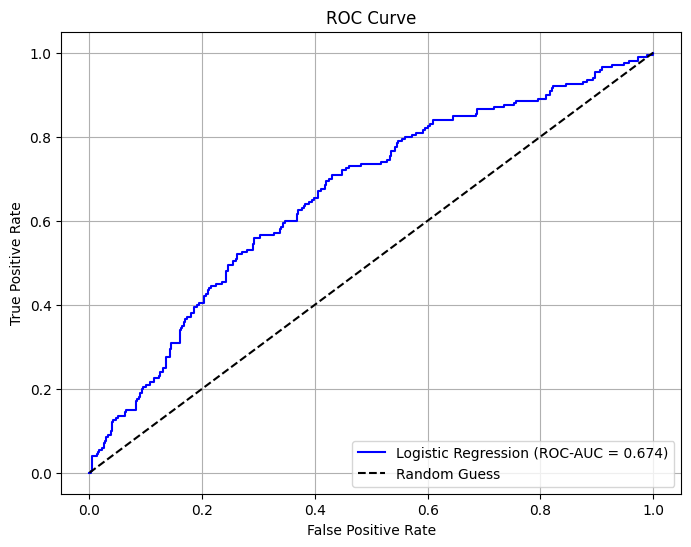

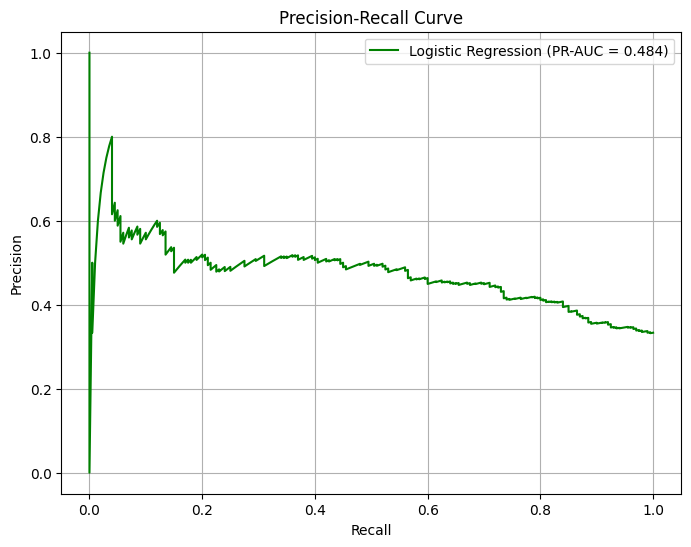

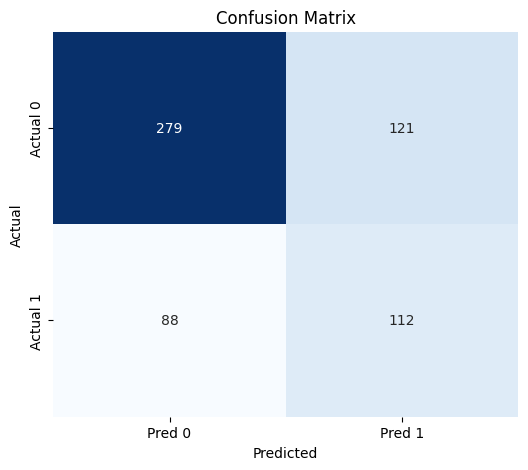

In [117]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import seaborn as sns

# ===== ROC Curve =====
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = 0.674375  # your model's ROC-AUC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression (ROC-AUC = {roc_auc:.3f})', color='blue')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# ===== Precision-Recall Curve =====
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba_lr)
pr_auc = 0.484099  # your model's PR-AUC
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'Logistic Regression (PR-AUC = {pr_auc:.3f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


# ===== Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


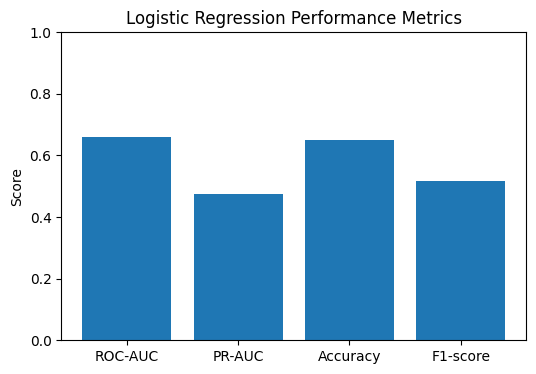

In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Compute metrics
roc_auc = roc_auc_score(y_test, y_proba_lr)
pr_auc = average_precision_score(y_test, y_proba_lr)
accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

# Create dictionary
metrics = {
    "ROC-AUC": roc_auc,
    "PR-AUC": pr_auc,
    "Accuracy": accuracy,
    "F1-score": f1
}

# Plot
plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values())
plt.title("Logistic Regression Performance Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


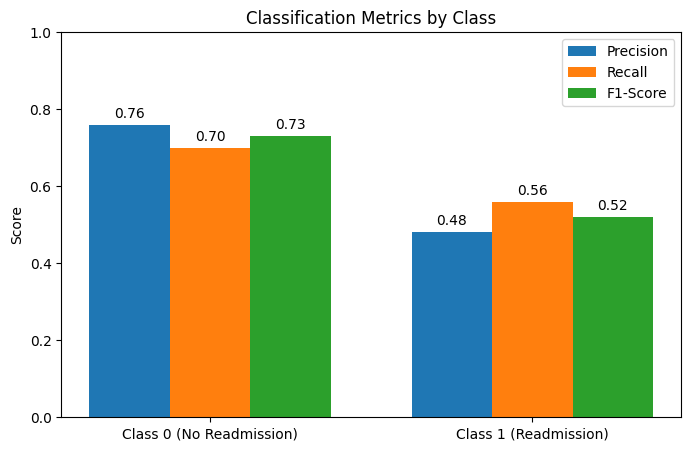

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each class
metrics = {
    'Precision': [0.76, 0.48],
    'Recall': [0.70, 0.56],
    'F1-Score': [0.73, 0.52]
}

classes = ['Class 0 (No Readmission)', 'Class 1 (Readmission)']
x = np.arange(len(classes))  # label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(8,5))

# Plot each metric
rects1 = ax.bar(x - width, metrics['Precision'], width, label='Precision')
rects2 = ax.bar(x, metrics['Recall'], width, label='Recall')
rects3 = ax.bar(x + width, metrics['F1-Score'], width, label='F1-Score')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1)  # scores range from 0 to 1
ax.legend()

# Add value labels on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.show()


In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

# Define Random Forest and hyperparameters
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search with 5-fold CV
grid_rf = GridSearchCV(
    rf, 
    rf_params, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1
)

# Fit the model
grid_rf.fit(X_train, y_train)

# Best model
best_rf = grid_rf.best_estimator_

# Predicted probabilities
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Adjust threshold (optional, e.g., 0.3) to improve recall for Class 1
threshold = 0.3
y_pred_rf = (y_proba_rf >= threshold).astype(int)

# Evaluation
print("=== Random Forest ===")
print("Best Hyperparameters:", grid_rf.best_params_)
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC:", average_precision_score(y_test, y_proba_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


=== Random Forest ===
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
ROC-AUC: 0.7276125
PR-AUC: 0.5576688438788177

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.63      0.71       400
           1       0.49      0.72      0.59       200

    accuracy                           0.66       600
   macro avg       0.66      0.68      0.65       600
weighted avg       0.71      0.66      0.67       600

Confusion Matrix:
 [[253 147]
 [ 56 144]]


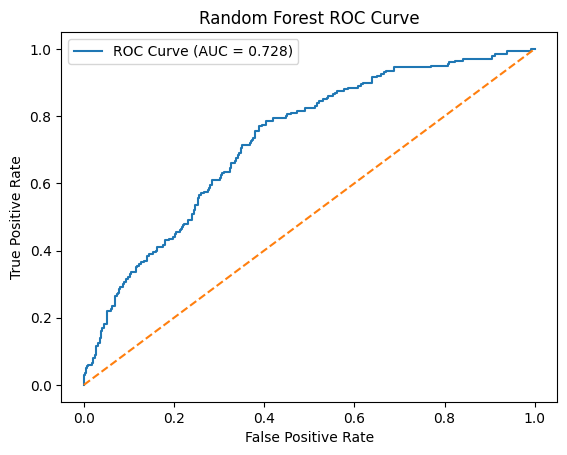

In [143]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.show()



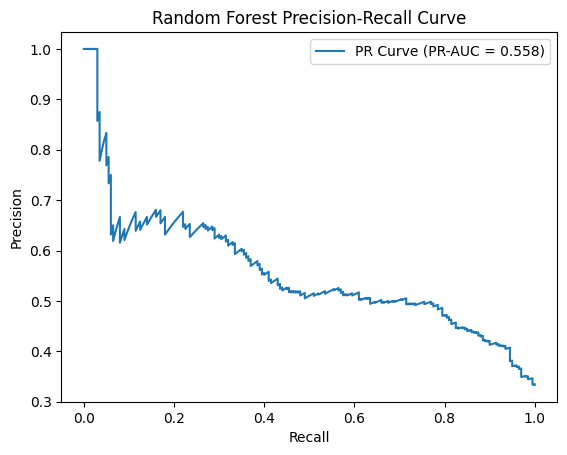

In [144]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)
pr_auc = average_precision_score(y_test, y_proba_rf)

plt.figure()
plt.plot(recall, precision, label=f'PR Curve (PR-AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision-Recall Curve')
plt.legend()
plt.show()


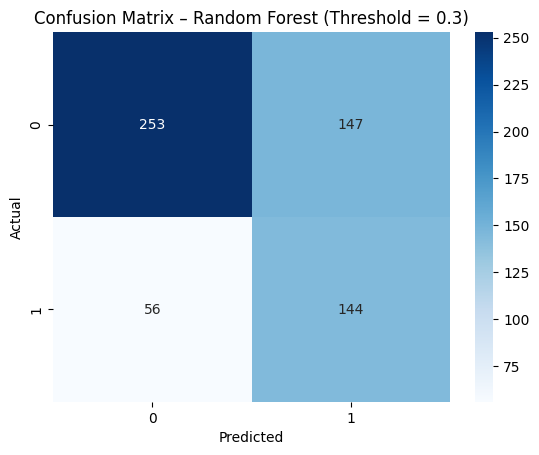

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest (Threshold = 0.3)")
plt.show()


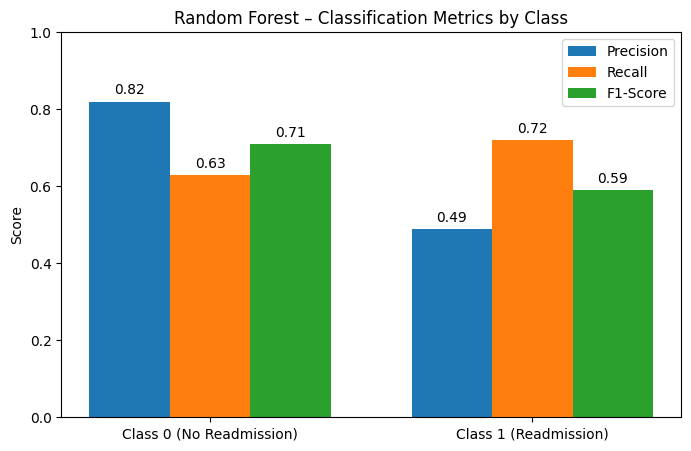

In [148]:
import matplotlib.pyplot as plt
import numpy as np

# Updated metrics after threshold adjustment
metrics = {
    'Precision': [0.82, 0.49],   # Class 0, Class 1
    'Recall': [0.63, 0.72],
    'F1-Score': [0.71, 0.59]
}

classes = ['Class 0 (No Readmission)', 'Class 1 (Readmission)']
x = np.arange(len(classes))  # label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(8,5))

# Plot each metric
rects1 = ax.bar(x - width, metrics['Precision'], width, label='Precision')
rects2 = ax.bar(x, metrics['Recall'], width, label='Recall')
rects3 = ax.bar(x + width, metrics['F1-Score'], width, label='F1-Score')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('Random Forest – Classification Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1)  # scores range from 0 to 1
ax.legend()

# Add value labels on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.show()


In [120]:
# Convert object columns (True/False or string) to 0/1
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].map({'False': 0, 'True': 1})
    X_test[col] = X_test[col].map({'False': 0, 'True': 1})

# If there are still missing values, fill them with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)


In [121]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define XGBoost
xgb = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter grid
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

# Create GridSearchCV object
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_params,
    cv=5,
    scoring='average_precision',
    n_jobs=-1
)

# Fit after defining GridSearchCV
grid_xgb.fit(X_train, y_train)

# Get best model
# Best model from grid search
xgb_best = grid_xgb.best_estimator_

# Predictions
xgb_pred = xgb_best.predict(X_test)
xgb_proba = xgb_best.predict_proba(X_test)[:, 1]

print("=== XGBoost ===")
print("Best Hyperparameters:", grid_xgb.best_params_)
print("ROC-AUC:", roc_auc_score(y_test, xgb_proba))
print("PR-AUC:", average_precision_score(y_test, xgb_proba))

print("\nClassification Report:\n", classification_report(y_test, xgb_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))



C:\Users\monic\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
Best Hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
ROC-AUC: 0.771825
PR-AUC: 0.5941664167068239

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80       400
           1       0.60      0.41      0.49       200

    accuracy                           0.71       600
   macro avg       0.67      0.64      0.64       600
weighted avg       0.70      0.71      0.70       600

Confusion Matrix:
 [[344  56]
 [117  83]]


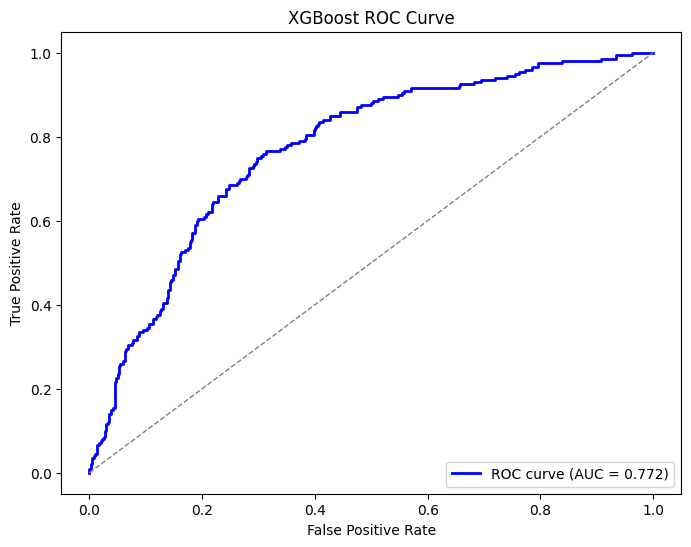

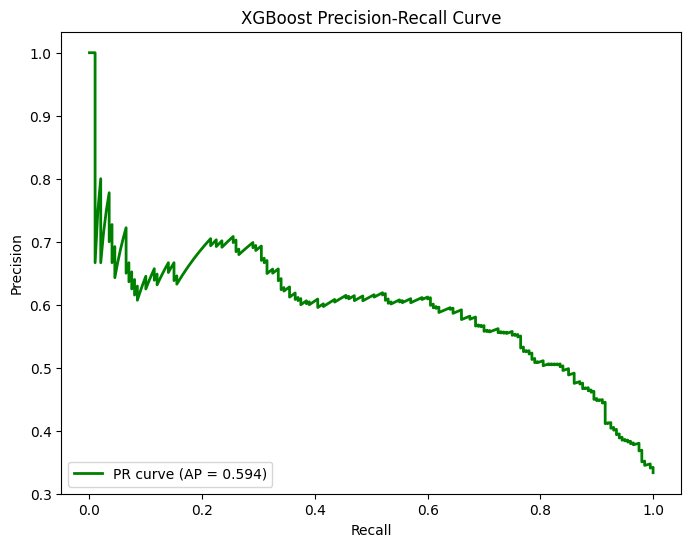

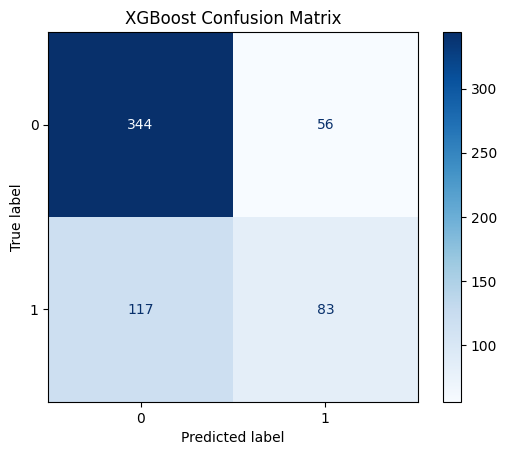

In [122]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, xgb_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.show()

# === Precision-Recall Curve ===
precision, recall, pr_thresholds = precision_recall_curve(y_test, xgb_proba)
pr_auc = average_precision_score(y_test, xgb_proba)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(y_test, xgb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_best.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix")
plt.show()


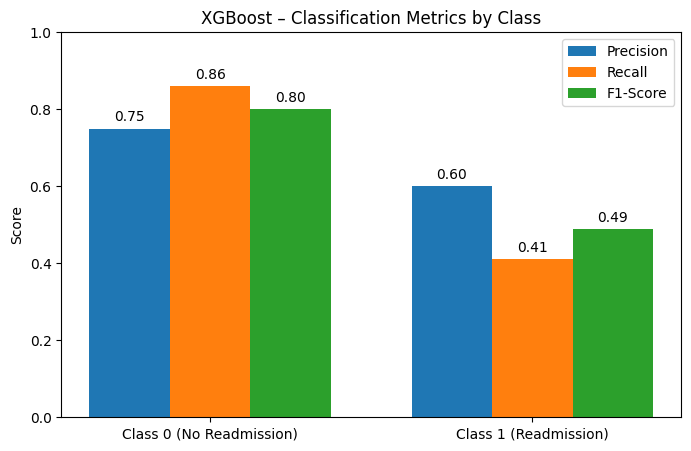

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each class
metrics = {
    'Precision': [0.75, 0.60],
    'Recall': [0.86, 0.41],
    'F1-Score': [0.80, 0.49]
}

classes = ['Class 0 (No Readmission)', 'Class 1 (Readmission)']
x = np.arange(len(classes))  # label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(8,5))

# Plot each metric
rects1 = ax.bar(x - width, metrics['Precision'], width, label='Precision')
rects2 = ax.bar(x, metrics['Recall'], width, label='Recall')
rects3 = ax.bar(x + width, metrics['F1-Score'], width, label='F1-Score')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('XGBoost – Classification Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1)  # scores range from 0 to 1
ax.legend()

# Add value labels on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.show()


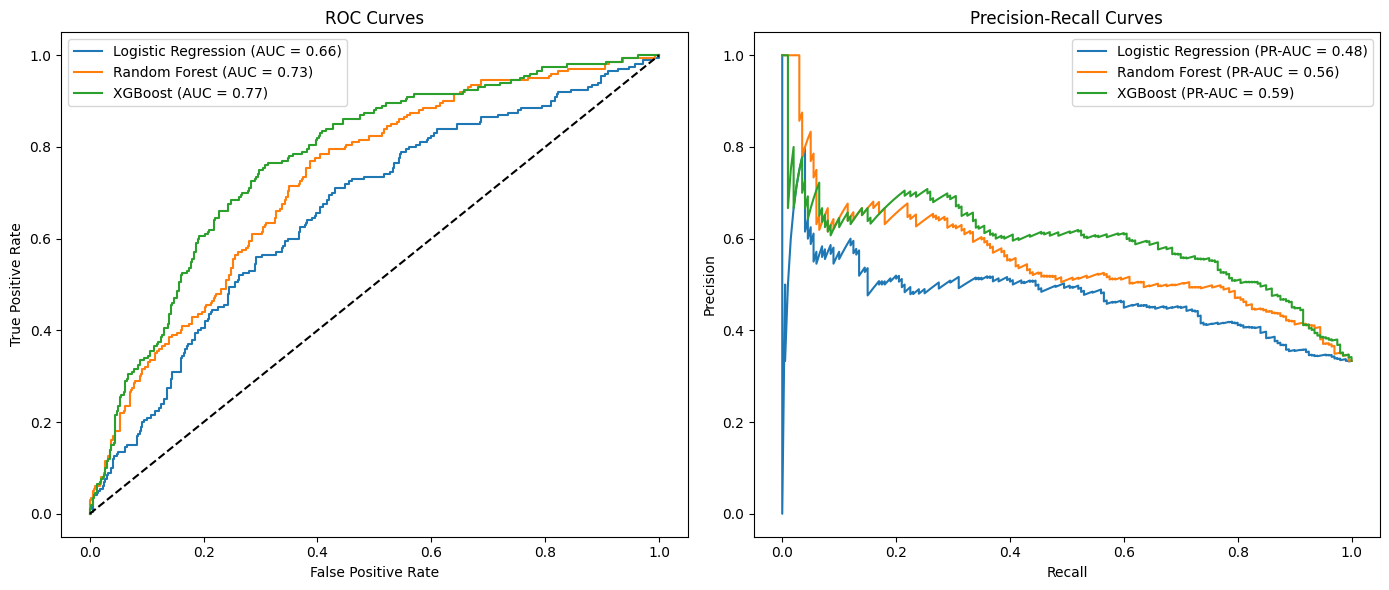

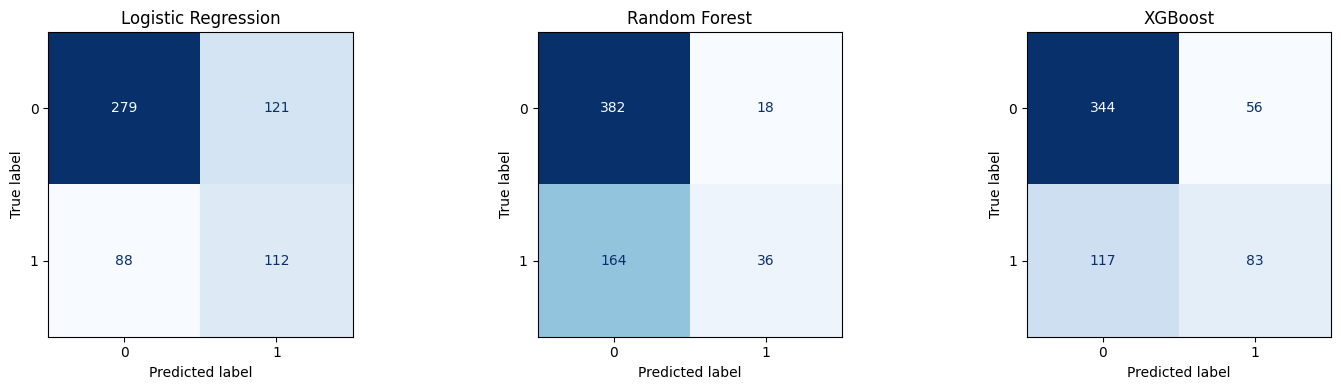

In [123]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay

# List of models and names
models = [
    ('Logistic Regression', best_lr),
    ('Random Forest', best_rf),
    ('XGBoost', xgb_best)
]

plt.figure(figsize=(14, 6))

# 1️⃣ ROC Curves
plt.subplot(1, 2, 1)
for name, model in models:
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# 2️⃣ Precision-Recall Curves
plt.subplot(1, 2, 2)
for name, model in models:
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f'{name} (PR-AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()

plt.tight_layout()
plt.show()

# 3️⃣ Confusion Matrices (side by side)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, model) in zip(axes, models):
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(name)
plt.tight_layout()
plt.show()


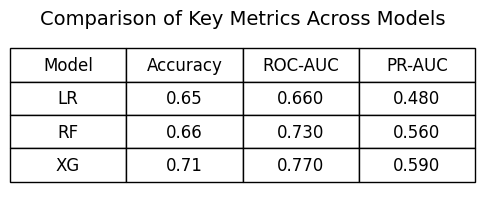

In [150]:
import matplotlib.pyplot as plt

# Metrics for each model
models = ['LR', 'RF', 'XG']
accuracy = [0.65, 0.66, 0.71]  # RF updated
roc_auc = [0.66, 0.73, 0.77]   # RF same
pr_auc = [0.48, 0.56, 0.59]    # RF same

# Create figure
fig, ax = plt.subplots(figsize=(6,2))
ax.axis('off')  # hide axes

# Create table
table_data = []
for i in range(len(models)):
    table_data.append([models[i], f"{accuracy[i]:.2f}", f"{roc_auc[i]:.3f}", f"{pr_auc[i]:.3f}"])

column_labels = ["Model", "Accuracy", "ROC-AUC", "PR-AUC"]
table = ax.table(cellText=table_data, colLabels=column_labels, loc='center', cellLoc='center')

# Format table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)  # scale width and height

plt.title("Comparison of Key Metrics Across Models", fontsize=14, pad=10)
plt.show()


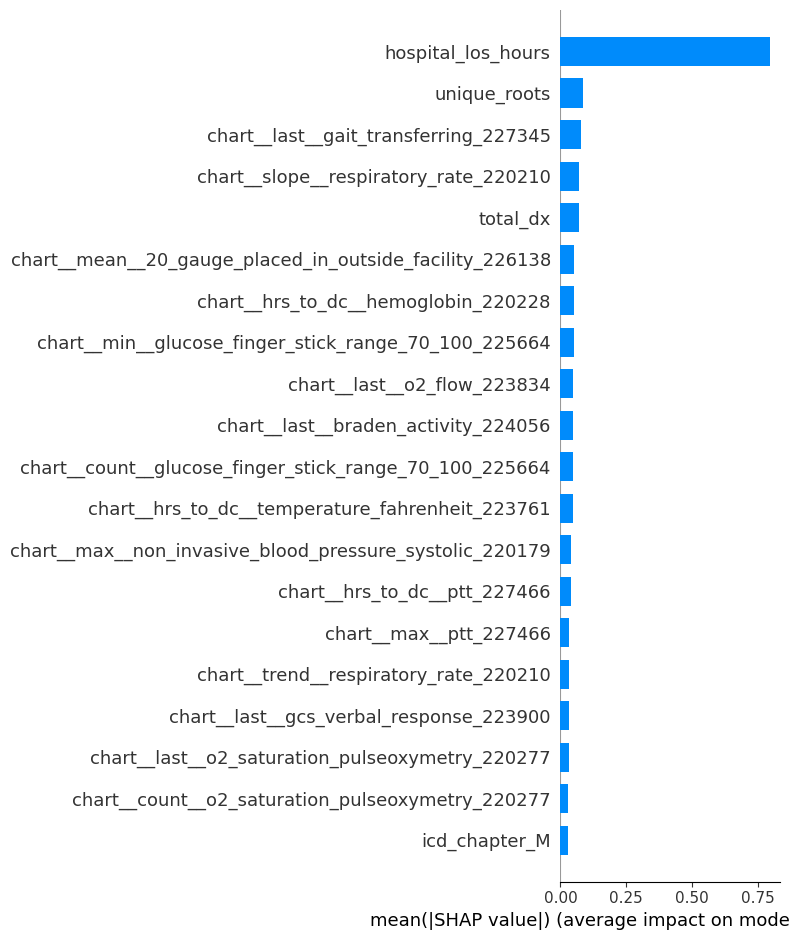

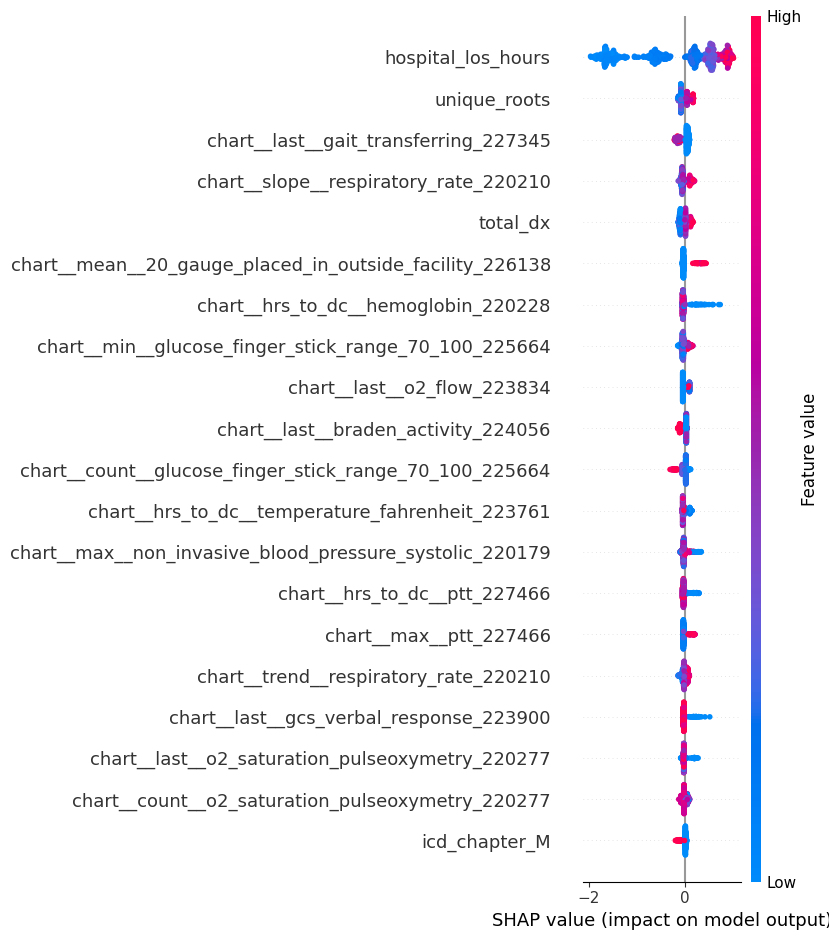

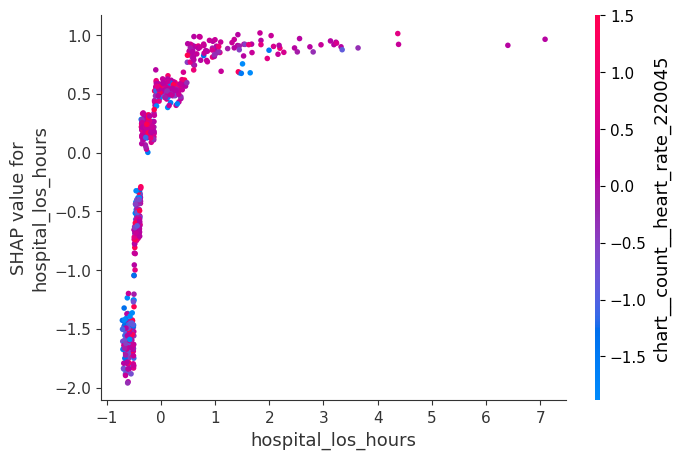

In [139]:
import shap
import matplotlib.pyplot as plt

# Explainer for XGBoost
explainer = shap.TreeExplainer(xgb_best)  
shap_values = explainer.shap_values(X_test)  # Use the test set

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")  # Bar plot: feature importance ranking
shap.summary_plot(shap_values, X_test)  # Dot plot: shows impact and direction

# Optional: Dependence plot for the top feature
shap.dependence_plot("hospital_los_hours", shap_values, X_test)


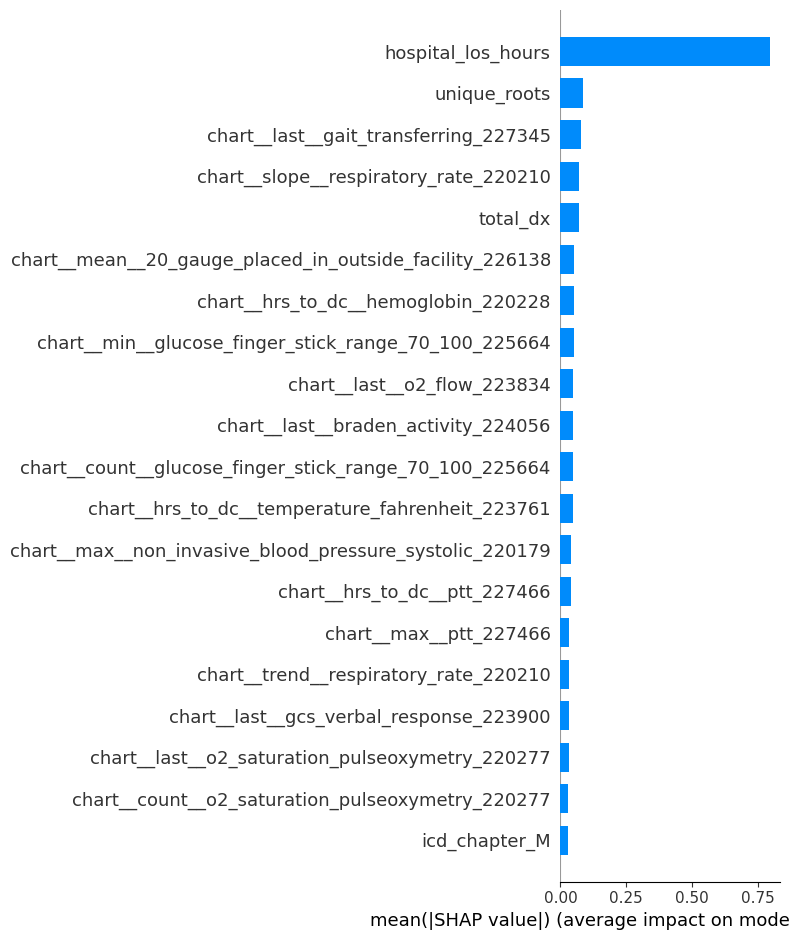

In [125]:
import shap
import matplotlib.pyplot as plt

# Explainer
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test)

# Bar plot for feature importance (most predictive first)
shap.summary_plot(shap_values, X_test, plot_type="bar")
